In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
#!pip install python-binance -qq
!pip install -qq wandb
#!conda install -c conda-forge sktime-all-extras -y
!pip install sktime
!pip install -qq --upgrade tsfresh
!pip install scipy==1.5

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.8.0 requires tf-estimator-nightly==2.8.0.dev2021122109, which is not installed.
matrixprofile 1.1.10 requires protobuf==3.11.2, but you have protobuf 3.19.4 which is incompatible.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.8.0 requires tf-estimator-nightly==2.8.0.dev2021122109, which is not installed.
wandb 0.12.11 requires protobuf>=3.12.0, but you have protobuf 3.11.2 which is incompatible.
tensorflow-metadata 1.7.0 requires protobuf<4,>=3.13, but you have protobuf 3.11.2 which is incompatible.
googleapis-common-protos 1.55.0 requires protobuf>=3.12.0, but you have protobuf 3.11.2 which is incompatible.
google-api-core 1.26.3 requires protobuf>=3.12.0, but 

In [ ]:
!nvidia-smi --query-gpu=gpu_name,driver_version,memory.total --format=csv

name, driver_version, memory.total [MiB]
Tesla K80, 460.32.03, 11441 MiB


In [ ]:
#%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
import math
import numpy as np
#from numba import cuda
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm
from matplotlib.pyplot import figure
import statistics

from keras.layers import Dropout
from keras.callbacks import ModelCheckpoint,ReduceLROnPlateau
from tqdm.notebook import tqdm

#Importing the Libraries
%matplotlib inline
import matplotlib. pyplot as plt
import matplotlib
from sklearn.preprocessing import MinMaxScaler
from keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.dates as mandates
from sklearn.preprocessing import MinMaxScaler
from sklearn import linear_model
from keras.models import Sequential
from keras.layers import Dense
import keras.backend as K
from keras.callbacks import EarlyStopping
from keras.optimizers import adam_v2, adamax_v2, adadelta_v2, adagrad_v2, rmsprop_v2
#from keras.optimizers import Adam, Adamax, Adadelta, Adagrad
from keras.models import load_model
from keras.layers import LSTM, GRU, Flatten,BatchNormalization
from tensorflow.keras import regularizers
from keras.utils.vis_utils import plot_model
import keras
import pickle

import tsfresh
from tsfresh import extract_features, extract_relevant_features, select_features
from tsfresh.utilities.dataframe_functions import impute
from tsfresh.feature_extraction import ComprehensiveFCParameters
#from tsfresh.feature_extraction.settings import Feature_Extraction_Settings
#from sktime.transformers.series_as_features.summarize import TSFreshFeatureExtractor

from sklearn.metrics import classification_report, recall_score, precision_score

#from statsmodels.tsa.stattools import grangercausalitytests
from sklearn.metrics import classification_report
from datetime import datetime

from IPython.display import clear_output 
from scipy import signal
from sklearn.metrics import classification_report, recall_score, precision_score

from sktime.forecasting.model_selection import temporal_train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.decomposition import PCA
from tensorflow.keras.callbacks import LearningRateScheduler

In [ ]:
root = '/content/drive/MyDrive/'
path = root+'generate_dataset/ETHBUSD/'

In [ ]:
#path = '/home/kurniawan/dataset/'

## **Feature**

In [ ]:
df = pd.read_csv(path+"ETHBUSD-5m-data.csv", parse_dates=['timestamp'])
del df['close_time']
del df['quote_av']
del df['tb_base_av']
del df['tb_quote_av']
del df['ignore']

# volume / trades
vt_mult = 1
df['vt'] = ( df['volume']/df['trades'] ) * vt_mult
del df['trades']
del df['volume']

# precentage change
pct_mult = 2500
df['pct_change'] = df['close'].pct_change(1)
df['pct_change'] = (df['pct_change'] +1 ) * 100
#df['pct_change'] = ( df['pct_change'] + 1 ) * pct_mult
df.dropna(inplace=True)

# movement
fee = 0.0016
move_mult = 1
df['move'] = df['pct_change'].apply(lambda x: 1 if x > (fee+1)*100 else 0)
#del df['pct_change_ori']
df['move'] = df['move'] * move_mult

#
timeframe_day = int(( 60 / 5 ) * 24)
timeframe = int( timeframe_day * 365.25/13) +1
df = df.iloc[-(timeframe):-1]
df.reset_index(inplace=True)
del df['index']
df

,timestamp,open,high,low,close,vt,pct_change,move
0,2022-02-13 10:05:00,2915.00,2915.00,2910.59,2910.87,0.254554,99.858319,0
1,2022-02-13 10:10:00,2910.87,2918.73,2910.84,2914.46,0.264711,100.123331,0
2,2022-02-13 10:15:00,2914.22,2920.00,2913.86,2920.00,0.254703,100.190087,1
3,2022-02-13 10:20:00,2919.99,2919.99,2915.62,2918.46,0.235215,99.947260,0
4,2022-02-13 10:25:00,2918.49,2919.07,2917.07,2918.99,0.174969,100.018160,0
...,...,...,...,...,...,...,...,...
8086,2022-03-13 11:55:00,2571.82,2575.14,2570.98,2574.72,0.405036,100.111593,0
8087,2022-03-13 12:00:00,2574.72,2575.68,2572.28,2572.69,0.289774,99.921156,0
8088,2022-03-13 12:05:00,2572.38,2572.50,2568.92,2572.40,0.251424,99.988728,0
8089,2022-03-13 12:05:00,2572.38,2572.50,2568.92,2572.40,0.251424,100.000000,0


### **tsfresh**

In [ ]:
features = ['open', 'high', 'low', 'vt', 'pct_change', 'move']
target = 'close'

In [ ]:
# 2D dataframe
#X = pd.DataFrame()
#for i, ts in tqdm(enumerate( np.array(df[features]) ), total=len(df[features])):
#    data = [[x, i] for x in ts]
#    X = X.append(data, ignore_index=True)
#X.columns = ['value', 'id']

In [ ]:
X = df[features]
X['id'] = np.arange(0,len(df))
#X = df.copy()
X

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,open,high,low,vt,pct_change,move,id
0,2915.00,2915.00,2910.59,0.254554,99.858319,0,0
1,2910.87,2918.73,2910.84,0.264711,100.123331,0,1
2,2914.22,2920.00,2913.86,0.254703,100.190087,1,2
3,2919.99,2919.99,2915.62,0.235215,99.947260,0,3
4,2918.49,2919.07,2917.07,0.174969,100.018160,0,4
...,...,...,...,...,...,...,...
8086,2571.82,2575.14,2570.98,0.405036,100.111593,0,8086
8087,2574.72,2575.68,2572.28,0.289774,99.921156,0,8087
8088,2572.38,2572.50,2568.92,0.251424,99.988728,0,8088
8089,2572.38,2572.50,2568.92,0.251424,100.000000,0,8089


In [ ]:
from tsfresh import extract_relevant_features

features_filtered_direct = extract_relevant_features(X, df[target], column_id='id')
impute(features_filtered_direct)
features_filtered_direct.head()

Feature Extraction: 100%|██████████| 48546/48546 [33:02<00:00, 24.49it/s]


,open__sum_values,high__quantile__q_0.7,high__quantile__q_0.8,high__quantile__q_0.9,"high__cwt_coefficients__coeff_0__w_5__widths_(2, 5, 10, 20)","high__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)","high__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)","high__fft_coefficient__attr_""real""__coeff_0","high__fft_coefficient__attr_""abs""__coeff_0",low__sum_values,...,vt__maximum,vt__quantile__q_0.3,vt__mean,vt__median,vt__abs_energy,vt__sum_values,vt__benford_correlation,low__benford_correlation,open__benford_correlation,high__benford_correlation
0,2915.00,2915.00,2915.00,2915.00,1130.668927,799.503666,565.334463,2915.00,2915.00,2910.59,...,0.254554,0.254554,0.254554,0.254554,0.064798,0.254554,0.295657,0.295657,0.295657,0.295657
1,2910.87,2918.73,2918.73,2918.73,1132.115718,800.526701,566.057859,2918.73,2918.73,2910.84,...,0.264711,0.264711,0.264711,0.264711,0.070072,0.264711,0.295657,0.295657,0.295657,0.295657
2,2914.22,2920.00,2920.00,2920.00,1132.608325,800.875027,566.304162,2920.00,2920.00,2913.86,...,0.254703,0.254703,0.254703,0.254703,0.064874,0.254703,0.295657,0.295657,0.295657,0.295657
3,2919.99,2919.99,2919.99,2919.99,1132.604446,800.872284,566.302223,2919.99,2919.99,2915.62,...,0.235215,0.235215,0.235215,0.235215,0.055326,0.235215,0.295657,0.295657,0.295657,0.295657
4,2918.49,2919.07,2919.07,2919.07,1132.247597,800.619954,566.123798,2919.07,2919.07,2917.07,...,0.174969,0.174969,0.174969,0.174969,0.030614,0.174969,0.864123,0.295657,0.295657,0.295657


In [ ]:
sf = select_features(features_filtered_direct, df[target])
sf.head()

,open__sum_values,open__abs_energy,open__median,open__mean,open__root_mean_square,open__maximum,open__absolute_maximum,open__minimum,open__quantile__q_0.1,open__quantile__q_0.2,...,"vt__fft_coefficient__attr_""real""__coeff_0","vt__cwt_coefficients__coeff_0__w_2__widths_(2, 5, 10, 20)",vt__quantile__q_0.9,vt__quantile__q_0.8,vt__quantile__q_0.7,vt__quantile__q_0.4,vt__benford_correlation,low__benford_correlation,open__benford_correlation,high__benford_correlation
0,2915.00,8.497225e+06,2915.00,2915.00,2915.00,2915.00,2915.00,2915.00,2915.00,2915.00,...,0.254554,0.156116,0.254554,0.254554,0.254554,0.254554,0.295657,0.295657,0.295657,0.295657
1,2910.87,8.473164e+06,2910.87,2910.87,2910.87,2910.87,2910.87,2910.87,2910.87,2910.87,...,0.264711,0.162345,0.264711,0.264711,0.264711,0.264711,0.295657,0.295657,0.295657,0.295657
2,2914.22,8.492678e+06,2914.22,2914.22,2914.22,2914.22,2914.22,2914.22,2914.22,2914.22,...,0.254703,0.156207,0.254703,0.254703,0.254703,0.254703,0.295657,0.295657,0.295657,0.295657
3,2919.99,8.526342e+06,2919.99,2919.99,2919.99,2919.99,2919.99,2919.99,2919.99,2919.99,...,0.235215,0.144255,0.235215,0.235215,0.235215,0.235215,0.295657,0.295657,0.295657,0.295657
4,2918.49,8.517584e+06,2918.49,2918.49,2918.49,2918.49,2918.49,2918.49,2918.49,2918.49,...,0.174969,0.107307,0.174969,0.174969,0.174969,0.174969,0.864123,0.295657,0.295657,0.295657


In [ ]:
with open(path+'features.pickle', 'wb') as handle:
    pickle.dump(sf[:1], handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
with open(path+'features.pickle', 'rb') as handle:
    col = pickle.load(handle)

In [ ]:
kind_to_fc_parameters = tsfresh.feature_extraction.settings.from_columns(col)

In [ ]:
ef = extract_features(X, column_id = 'id',
                      kind_to_fc_parameters = kind_to_fc_parameters)
ef.head()

Feature Extraction: 100%|██████████| 48546/48546 [01:50<00:00, 438.00it/s]


,open__sum_values,open__abs_energy,open__median,open__mean,open__root_mean_square,open__maximum,open__absolute_maximum,open__minimum,open__quantile__q_0.1,open__quantile__q_0.2,...,vt__abs_energy,vt__sum_values,vt__root_mean_square,"vt__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)","vt__cwt_coefficients__coeff_0__w_5__widths_(2, 5, 10, 20)","vt__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)","vt__cwt_coefficients__coeff_0__w_2__widths_(2, 5, 10, 20)","vt__fft_coefficient__attr_""abs""__coeff_0","vt__fft_coefficient__attr_""real""__coeff_0",vt__benford_correlation
0,2915.00,8.497225e+06,2915.00,2915.00,2915.00,2915.00,2915.00,2915.00,2915.00,2915.00,...,0.064798,0.254554,0.254554,0.069817,0.098736,0.049368,0.156116,0.254554,0.254554,0.295657
1,2910.87,8.473164e+06,2910.87,2910.87,2910.87,2910.87,2910.87,2910.87,2910.87,2910.87,...,0.070072,0.264711,0.264711,0.072603,0.102676,0.051338,0.162345,0.264711,0.264711,0.295657
2,2914.22,8.492678e+06,2914.22,2914.22,2914.22,2914.22,2914.22,2914.22,2914.22,2914.22,...,0.064874,0.254703,0.254703,0.069858,0.098794,0.049397,0.156207,0.254703,0.254703,0.295657
3,2919.99,8.526342e+06,2919.99,2919.99,2919.99,2919.99,2919.99,2919.99,2919.99,2919.99,...,0.055326,0.235215,0.235215,0.064513,0.091235,0.045617,0.144255,0.235215,0.235215,0.295657
4,2918.49,8.517584e+06,2918.49,2918.49,2918.49,2918.49,2918.49,2918.49,2918.49,2918.49,...,0.030614,0.174969,0.174969,0.047989,0.067867,0.033933,0.107307,0.174969,0.174969,0.864123


In [ ]:
sf.columns == ef[sf.columns].columns 

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True])

### **PCA**

In [ ]:
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(ef[col])
principalDf = pd.DataFrame(principalComponents, columns=['1', '2'])
principalDf

,1,2
0,1.616012e+06,-21241.245418
1,1.615532e+06,-4740.134496
2,1.641230e+06,-12365.769866
3,1.666552e+06,-21411.264666
4,1.663268e+06,-30529.189446
...,...,...
8086,-1.623182e+06,-20367.904308
8087,-1.609101e+06,-23756.971382
8088,-1.635479e+06,-23390.534776
8089,-1.635479e+06,-23390.534776


In [ ]:
pca.explained_variance_ratio_

array([9.99633748e-01, 2.40433112e-04])

In [ ]:
sum(pca.explained_variance_ratio_)

0.9998741810550703

### **Scaler**

In [ ]:
scaler1 = MinMaxScaler(feature_range=(1700,2600))
scaler2 = MinMaxScaler(feature_range=(1700,2600))

scaler1.fit( pd.DataFrame( principalDf['1']) )
scaler2.fit( pd.DataFrame( principalDf['2']) )

MinMaxScaler(feature_range=(1700, 2600))

In [ ]:
data1 = scaler1.transform( pd.DataFrame( principalDf['1']) )
data2 = scaler2.transform( pd.DataFrame( principalDf['2']) )

## **Prepro** 

In [ ]:
def create_dataset(data, look_back):
  return 0

In [ ]:
features = ['open', 'high', 'low', 'vt', 'pct_change', 'move' , 'pca1', 'pca2']
target = 'close'
df['pca1'] = data1
df['pca2'] = data2
df

,timestamp,open,high,low,close,vt,pct_change,move,pca1,pca2
0,2022-02-13 10:05:00,2915.00,2915.00,2910.59,2910.87,0.254554,99.858319,0,2285.529783,1727.244601
1,2022-02-13 10:10:00,2910.87,2918.73,2910.84,2914.46,0.264711,100.123331,0,2285.478333,1759.554323
2,2022-02-13 10:15:00,2914.22,2920.00,2913.86,2920.00,0.254703,100.190087,1,2288.236334,1744.623076
3,2022-02-13 10:20:00,2919.99,2919.99,2915.62,2918.46,0.235215,99.947260,0,2290.953959,1726.911698
4,2022-02-13 10:25:00,2918.49,2919.07,2917.07,2918.99,0.174969,100.018160,0,2290.601493,1709.058499
...,...,...,...,...,...,...,...,...,...,...
8086,2022-03-13 11:55:00,2571.82,2575.14,2570.98,2574.72,0.405036,100.111593,0,1937.889025,1728.954632
8087,2022-03-13 12:00:00,2574.72,2575.68,2572.28,2572.69,0.289774,99.921156,0,1939.400319,1722.318726
8088,2022-03-13 12:05:00,2572.38,2572.50,2568.92,2572.40,0.251424,99.988728,0,1936.569341,1723.036221
8089,2022-03-13 12:05:00,2572.38,2572.50,2568.92,2572.40,0.251424,100.000000,0,1936.569341,1723.036221


In [ ]:
y_train, y_test, x_train, x_test = temporal_train_test_split(y = np.array(df[target]),
                                                             X = np.array(df[features]),
                                                             #test_size = int(timeframe_day * 7))
                                                             test_size = 1440 ) 

In [ ]:
look_back = 1
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], look_back))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], look_back))

In [ ]:
x_train.shape

(6651, 8, 1)

In [ ]:
#del df

## **Model**

In [ ]:
nodes = 80
lookback = 1
bias = True
#nodes = config.nodes

model = Sequential()

model.add(GRU(int(nodes/10*lookback), input_shape=(x_train.shape[1],x_train.shape[2]), use_bias=bias, activation = "elu", 
              return_sequences=True,  activity_regularizer='l1'))
model.add(GRU(int(nodes*lookback), use_bias=bias, activation = "elu", return_sequences=True, activity_regularizer='l1'))
model.add(GRU(int(nodes*lookback), use_bias=bias, activation = "elu", return_sequences=True, activity_regularizer='l1'))
model.add(GRU(int(nodes*lookback), use_bias=bias, activation = "elu", return_sequences=True, activity_regularizer='l1'))
model.add(GRU((nodes*lookback), use_bias=bias, activation = "elu", activity_regularizer='l1'))
#model.add(Dropout(0.001))
model.add(Flatten())
model.add(Dense(int(nodes*lookback),  use_bias=bias, activation = "elu", activity_regularizer='l1'))
model.add(Dense(int(nodes*lookback*0.8),  use_bias=bias, activation = "elu", activity_regularizer='l1'))
model.add(Dense(int(nodes*lookback*0.6),  use_bias=bias, activation = "elu", activity_regularizer='l1'))
model.add(Dense(int(nodes*lookback*0.4),  use_bias=bias, activation = "elu", activity_regularizer='l1'))
model.add(Dense(int(nodes*lookback*0.2),  activation = "elu", activity_regularizer='l1'))
model.add(Dense(int(nodes*lookback*0.1),  activation = "elu", activity_regularizer='l1'))
model.add(Dense(1, use_bias=bias, activation = "elu", activity_regularizer='l1'))


In [ ]:
nodes = 80
lookback = 1
bias = True
#nodes = config.nodes

model = Sequential()

model.add(GRU(int(nodes*0.1), input_shape=(x_train.shape[1],x_train.shape[2]), use_bias=bias, activation = "elu", 
              return_sequences=True,  activity_regularizer='l1'))
model.add(GRU(int(nodes*0.2), use_bias=bias, activation = "elu", return_sequences=True, activity_regularizer='l1'))
model.add(GRU(int(nodes*0.4), use_bias=bias, activation = "elu", return_sequences=True, activity_regularizer='l1'))
model.add(GRU(int(nodes*0.6), use_bias=bias, activation = "elu", return_sequences=True, activity_regularizer='l1'))
model.add(GRU(int(nodes*0.8), use_bias=bias, activation = "elu", return_sequences=True, activity_regularizer='l1'))
model.add(GRU(int(nodes), use_bias=bias, activation = "elu", return_sequences=True, activity_regularizer='l1'))
model.add(GRU((nodes*lookback), use_bias=bias, activation = "elu", activity_regularizer='l1'))
#model.add(Dropout(0.001))
model.add(Flatten())
model.add(Dense(int(nodes*lookback),  use_bias=bias, activation = "elu", activity_regularizer='l1'))
model.add(Dense(int(nodes*lookback),  use_bias=bias, activation = "elu", activity_regularizer='l1'))
model.add(Dense(int(nodes*lookback*0.8),  use_bias=bias, activation = "elu", activity_regularizer='l1'))
model.add(Dense(int(nodes*lookback*0.6),  use_bias=bias, activation = "elu", activity_regularizer='l1'))
model.add(Dense(int(nodes*lookback*0.4),  use_bias=bias, activation = "elu", activity_regularizer='l1'))
model.add(Dense(int(nodes*lookback*0.2),  activation = "elu", activity_regularizer='l1'))
model.add(Dense(int(nodes*lookback*0.1),  activation = "elu", activity_regularizer='l1'))
model.add(Dense(1, use_bias=bias, activation = "elu", activity_regularizer='l1'))

### **Callbacks**

In [ ]:
initial_learning_rate = 0.001
epochs = 100
decay = initial_learning_rate / (epochs/10)
def lr_time_based_decay(epoch, lr):
    return lr * 1 / (1 + decay * epoch)

In [ ]:
filepath = path+"weight.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='auto')
callbacks_list = [checkpoint,
                  LearningRateScheduler(lr_time_based_decay, verbose=1)] 

### **Fit**

In [ ]:
model.compile(loss='mean_absolute_error', optimizer= 'adam')
model.fit(x_train, y_train,
          epochs = epochs, batch_size = int(len(x_train)/2),
          #validation_data=(testX, y_test),
          #validation_data=(trainX[:5], y_train[:5]),
          verbose = 1, 
          shuffle = False,
          callbacks = callbacks_list)


Epoch 1: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 1/100
3/3 [==============================] - ETA: 0s - loss: 2866.4661
Epoch 1: loss improved from inf to 2866.46606, saving model to /content/drive/MyDrive/generate_dataset/ETHBUSD/weight.hdf5
3/3 [==============================] - 11s 482ms/step - loss: 2866.4661 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0009999000574917021.
Epoch 2/100
3/3 [==============================] - ETA: 0s - loss: 2856.3740
Epoch 2: loss improved from 2866.46606 to 2856.37402, saving model to /content/drive/MyDrive/generate_dataset/ETHBUSD/weight.hdf5
3/3 [==============================] - 1s 303ms/step - loss: 2856.3740 - lr: 9.9990e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.000999700106714659.
Epoch 3/100
3/3 [==============================] - ETA: 0s - loss: 2849.5691
Epoch 3: loss improved from 2856.37402 to 2849.56909, saving model to /content/drive/MyDrive/generate_da

## **Eval**

In [ ]:
model = load_model(filepath)

### **Predict**

In [ ]:
y_pred = model.predict(x_test)
y_pred = [x[0] for x in y_pred]

In [ ]:
len(y_pred)

1440

### **Profitability**

In [ ]:
eval = pd.DataFrame(y_test, columns = ['actual'])
eval['pred'] = y_pred

In [ ]:
moe = 0 
for i, row in eval.iterrows():
  moe+= row['actual'] - row['pred']
moe = moe/len(eval)
eval['pred_moe'] = eval['pred'] + moe

eval['actual_pct_change'] = eval['actual'].pct_change(1)
eval['pred_pct_change'] = eval['pred'].pct_change(1)
eval['pred_moe_pct_change'] = eval['pred_moe'].pct_change(1)
eval.dropna(inplace=True)

eval['actual_move'] = eval['actual_pct_change'].apply(lambda x: 1 if x>fee else 0)
eval['pred_move'] = eval['pred_pct_change'].apply(lambda x: 1 if x>fee else 0)
eval['pred_moe_move'] = eval['pred_moe_pct_change'].apply(lambda x: 1 if x>fee else 0)

eval

,actual,pred,pred_moe,actual_pct_change,pred_pct_change,pred_moe_pct_change,actual_move,pred_move,pred_moe_move
1,2576.53,2513.154541,2591.999023,-0.001264,-1.026630e-03,-9.954572e-04,0,0,0
2,2582.00,2512.198486,2591.042969,0.002123,-3.803968e-04,-3.688335e-04,1,0,0
3,2579.73,2516.525146,2595.369629,-0.000879,1.722217e-03,1.669884e-03,0,1,1
4,2571.57,2506.250000,2585.094482,-0.003163,-4.083097e-03,-3.959060e-03,0,0,0
5,2569.52,2508.950684,2587.795166,-0.000797,1.077533e-03,1.044750e-03,0,0,0
...,...,...,...,...,...,...,...,...,...
1435,2574.72,2511.654785,2590.499268,0.001116,2.504230e-03,2.427816e-03,0,1,1
1436,2572.69,2513.953369,2592.797852,-0.000788,9.151697e-04,8.872747e-04,0,0,0
1437,2572.40,2512.216309,2591.060791,-0.000113,-6.909966e-04,-6.699562e-04,0,0,0
1438,2572.40,2512.215332,2591.059814,0.000000,-4.172325e-07,-3.576279e-07,0,0,0


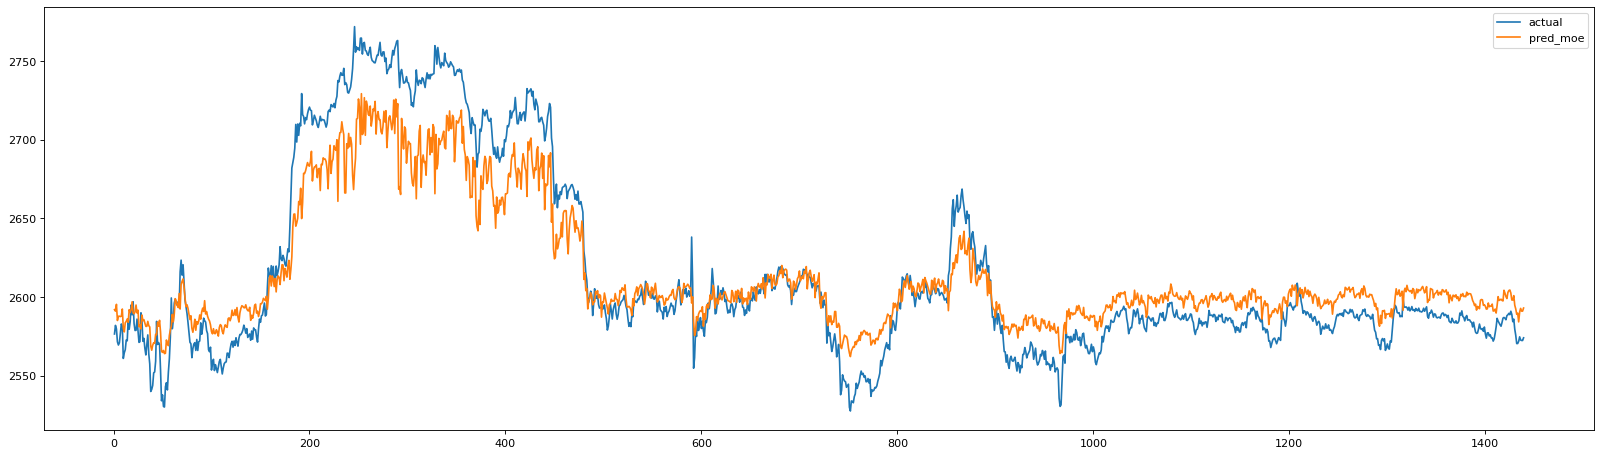

In [ ]:
figure(figsize=(25, 7), dpi=80)
plt.plot(eval['actual'], label='actual')
#plt.plot(eval['pred'], label='pred')
plt.plot(eval['pred_moe'], label='pred_moe')
plt.legend(loc='best')

In [ ]:
actual_profit = eval[eval['actual_move']==1]
init_asset = 100
asset = 0
for i, row in actual_profit.iterrows():
  asset+= init_asset * row['actual_pct_change']
print((asset/init_asset)*100)

profit = eval[eval['pred_move']==1]
init_asset = 100
asset = 0
for i, row in profit.iterrows():
  asset+= init_asset * row['actual_pct_change']
profit

70.65633527660592


,actual,pred,pred_moe,actual_pct_change,pred_pct_change,pred_moe_pct_change,actual_move,pred_move,pred_moe_move
3,2579.73,2516.525146,2595.369629,-0.000879,0.001722,0.001670,0,1,1
9,2581.13,2513.552002,2592.396484,-0.000678,0.001805,0.001750,0,1,1
12,2566.55,2504.821289,2583.665771,0.000772,0.002322,0.002251,0,1,1
16,2579.53,2513.150635,2591.995117,-0.002398,0.003202,0.003104,0,1,1
19,2588.72,2518.120361,2596.964844,-0.002405,0.001972,0.001912,0,1,1
...,...,...,...,...,...,...,...,...,...
1395,2580.16,2519.120361,2597.964844,-0.001030,0.002125,0.002061,0,1,1
1412,2586.48,2515.838623,2594.683105,0.002123,0.001925,0.001867,1,1,1
1413,2584.76,2521.415039,2600.259521,-0.000665,0.002217,0.002149,0,1,1
1419,2587.04,2525.469482,2604.313965,0.000159,0.002692,0.002610,0,1,1


In [ ]:
(asset/init_asset)*100

-0.42349528318817997

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(eval['actual_move'], eval['pred_move']))

              precision    recall  f1-score   support

           0       0.83      0.80      0.81      1213
           1       0.10      0.12      0.11       226

    accuracy                           0.69      1439
   macro avg       0.46      0.46      0.46      1439
weighted avg       0.71      0.69      0.70      1439

